In [1]:
import jax
import jax.numpy as jnp
from jax import random, vmap, grad, jit
from jax.flatten_util import ravel_pytree
from functools import partial
import optax
import flax.linen as nn
from tqdm import trange
import matplotlib.pyplot as plt
import scipy.io
import csv
import numpy as np

jax.config.update("jax_enable_x64", True)

print("JAX devices:", jax.devices())
print(f"JAX backend: {jax.default_backend()}")

JAX devices: [CudaDevice(id=0)]
JAX backend: gpu


In [2]:
# ==========================================
# PirateNet Architecture (Paper-Exact)
# ==========================================

class FourierEmbs(nn.Module):
    """Random Fourier Feature Embedding."""
    embed_scale: float
    embed_dim: int

    @nn.compact
    def __call__(self, x):
        kernel = self.param(
            "kernel",
            nn.initializers.normal(stddev=self.embed_scale),
            (x.shape[-1], self.embed_dim // 2)
        )
        return jnp.concatenate(
            [jnp.cos(jnp.dot(x, kernel)), jnp.sin(jnp.dot(x, kernel))], axis=-1
        )


class Dense(nn.Module):

    features: int
    use_reparam: bool = True
    reparam_mean: float = 1.0
    reparam_stddev: float = 0.1

    @nn.compact
    def __call__(self, x):
        if self.use_reparam:
            def weight_fact_init(key, shape):
                key1, key2 = random.split(key)
                w = nn.initializers.glorot_normal()(key1, shape)
                g = self.reparam_mean + nn.initializers.normal(self.reparam_stddev)(key2, (shape[-1],))
                g = jnp.exp(g)
                v = w / g
                return g, v
            g, v = self.param("kernel", weight_fact_init, (x.shape[-1], self.features))
            kernel = g * v
        else:
            kernel = self.param("kernel", nn.initializers.glorot_normal(), (x.shape[-1], self.features))
        bias = self.param("bias", nn.initializers.zeros, (self.features,))
        return jnp.dot(x, kernel) + bias


class PIModifiedBottleneck(nn.Module):
    hidden_dim: int
    output_dim: int
    activation: callable
    nonlinearity: float = 0.0
    use_reparam: bool = True

    @nn.compact
    def __call__(self, x, u, v):
        identity = x
        x = Dense(features=self.hidden_dim, use_reparam=self.use_reparam)(x)
        x = self.activation(x)
        x = x * u + (1 - x) * v
        x = Dense(features=self.hidden_dim, use_reparam=self.use_reparam)(x)
        x = self.activation(x)
        x = x * u + (1 - x) * v
        x = Dense(features=self.output_dim, use_reparam=self.use_reparam)(x)
        x = self.activation(x)
        alpha = self.param('alpha', nn.initializers.constant(self.nonlinearity), (1,))
        return alpha * x + (1 - alpha) * identity


class PirateNet(nn.Module):
    num_layers: int = 3
    hidden_dim: int = 256
    out_dim: int = 1
    activation: str = "tanh"
    nonlinearity: float = 0.0
    fourier_scale: float = 2.0
    fourier_dim: int = 256
    use_reparam: bool = True

    def setup(self):
        self.activation_fn = jnp.tanh if self.activation == "tanh" else nn.gelu

    @nn.compact
    def __call__(self, x):
        embs = FourierEmbs(embed_scale=self.fourier_scale, embed_dim=self.fourier_dim)(x)
        x = embs
        u = self.activation_fn(Dense(features=self.hidden_dim, use_reparam=self.use_reparam)(x))
        v = self.activation_fn(Dense(features=self.hidden_dim, use_reparam=self.use_reparam)(x))
        for i in range(self.num_layers):
            x = PIModifiedBottleneck(
                hidden_dim=self.hidden_dim, output_dim=x.shape[-1],
                activation=self.activation_fn, nonlinearity=self.nonlinearity,
                use_reparam=self.use_reparam, name=f"block_{i}"
            )(x, u, v)
        y = Dense(features=self.out_dim, use_reparam=self.use_reparam)(x)
        return x, y

In [3]:
class CSVLogger:
    def __init__(self, filename, fieldnames):
        self.filename = filename
        self.fieldnames = fieldnames
        with open(filename, 'w', newline='') as f:
            csv.DictWriter(f, fieldnames=fieldnames).writeheader()

    def log(self, row_dict):
        with open(self.filename, 'a', newline='') as f:
            csv.DictWriter(f, fieldnames=self.fieldnames).writerow(row_dict)


class UniformSampler:
    def __init__(self, dom, batch_size, rng_key=random.PRNGKey(1234)):
        self.dom = dom
        self.batch_size = batch_size
        self.key = rng_key

    def sample(self):
        self.key, subkey = random.split(self.key)
        return random.uniform(subkey, shape=(self.batch_size, self.dom.shape[0]),
                              minval=self.dom[:, 0], maxval=self.dom[:, 1])

In [4]:
class VanillaPirateNetTrainer:
    def __init__(self, config):
        self.config = config
        self.pde_type = config['pde_type']

        # Initialize model
        self.model = PirateNet(
            num_layers=config['num_layers'],
            hidden_dim=config['hidden_dim'],
            out_dim=1,
            activation=config['activation'],
            nonlinearity=config['nonlinearity'],
            fourier_scale=config['fourier_scale'],
            fourier_dim=config['fourier_dim'],
            use_reparam=config['use_reparam'],
        )

        # Initialize parameters
        self.key = random.PRNGKey(config['seed'])
        self.key, init_key = random.split(self.key)
        self.params = self.model.init(init_key, jnp.ones((1, 2)))

        # LR schedule
        lr_schedule = optax.warmup_exponential_decay_schedule(
            init_value=0.0, peak_value=config['learning_rate'],
            warmup_steps=config['warmup_steps'], transition_steps=config['decay_steps'],
            decay_rate=config['decay_rate'], end_value=config['lr_end'],
        )
        self.tx = optax.adam(learning_rate=lr_schedule)
        self.opt_state = self.tx.init(self.params)

        # Loss weights
        self.weights = dict(config['init_weights'])
        self.weight_momentum = config['weight_momentum']

        # Causal weighting
        self.use_causal = config['use_causal']
        self.causal_tol = config['causal_tol']
        self.num_chunks = config['num_chunks']
        self.M = jnp.triu(jnp.ones((self.num_chunks, self.num_chunks)), k=1).T

        # Samplers
        self.dom = jnp.array(config['domain'])  # [[t_min, t_max], [x_min, x_max]]
        self.res_sampler = UniformSampler(self.dom, config['batch_size_res'])
        self.ic_sampler = UniformSampler(
            jnp.array([config['domain'][1]]),  # x domain only
            config['batch_size_ic']
        )
        self.bc_sampler = UniformSampler(
            jnp.array([config['domain'][0]]),  # t domain only
            config['batch_size_bc']
        )

        # CSV Logger
        self.csv_logger = CSVLogger(
            config['csv_filename'],
            ['step', 'loss_total', 'loss_ic', 'loss_bc', 'loss_res', 'lr', 'w_ic', 'w_bc', 'w_res']
        )

        # Reference data
        self.u_ref = None
        self.t_star = None
        self.x_star = None

        # Store IC/BC/PDE functions
        self.ic_fn = None
        self.bc_fn = None
        self.pde_fn = None

    def set_reference(self, t_star, x_star, u_ref):
        self.t_star, self.x_star, self.u_ref = t_star, x_star, u_ref

    def set_pde_functions(self, ic_fn, bc_fn, pde_fn):
        """Set IC, BC, and PDE residual functions."""
        self.ic_fn = ic_fn
        self.bc_fn = bc_fn
        self.pde_fn = pde_fn

    def u_net(self, params, t, x):
        _, y = self.model.apply(params, jnp.array([[t, x]]))
        return y[0, 0]

    def ic_loss(self, params, batch_ic):
        """IC loss using user-provided IC function."""
        x_ic = batch_ic[:, 0]
        t_ic = jnp.zeros_like(x_ic)
        u_ic_true = self.ic_fn(x_ic)
        u_ic_pred = vmap(lambda t, x: self.u_net(params, t, x))(t_ic, x_ic)
        return jnp.mean((u_ic_pred - u_ic_true)**2)

    def bc_loss(self, params, batch_bc):
        """BC loss using user-provided BC function."""
        t_bc = batch_bc[:, 0]
        return jnp.mean(vmap(lambda t: self.bc_fn(params, self.u_net, t))(t_bc))

    def res_loss_with_causal(self, params, batch_res):
        """Residual loss with causal weighting."""
        t_res, x_res = batch_res[:, 0], batch_res[:, 1]
        r_pred = vmap(lambda t, x: self.pde_fn(params, self.u_net, t, x))(t_res, x_res)
        r_sq = r_pred**2

        if not self.use_causal:
            return jnp.mean(r_sq), jnp.mean(r_sq)

        sort_idx = jnp.argsort(t_res)
        r_sq_sorted = r_sq[sort_idx]
        n_per_chunk = len(r_sq_sorted) // self.num_chunks
        r_sq_chunks = r_sq_sorted[:n_per_chunk * self.num_chunks].reshape(self.num_chunks, n_per_chunk)
        l_chunks = jnp.mean(r_sq_chunks, axis=1)
        w_causal = jnp.exp(-self.causal_tol * (self.M @ l_chunks))
        weighted_loss = jnp.sum(w_causal * l_chunks) / jnp.sum(w_causal)
        return weighted_loss, jnp.mean(r_sq)

    def total_loss(self, params, weights, batch_ic, batch_bc, batch_res):
        l_ic = self.ic_loss(params, batch_ic)
        l_bc = self.bc_loss(params, batch_bc)
        l_res, l_res_raw = self.res_loss_with_causal(params, batch_res)
        losses = {'ic': l_ic, 'bc': l_bc, 'res': l_res_raw}
        total = weights['ic'] * l_ic + weights['bc'] * l_bc + weights['res'] * l_res
        return total, losses

    def compute_ntk_weights(self, params, batch_ic, batch_bc, batch_res):
        def flatten(pytree):
            return ravel_pytree(pytree)[0]
        grad_ic = flatten(grad(lambda p: self.ic_loss(p, batch_ic))(params))
        grad_bc = flatten(grad(lambda p: self.bc_loss(p, batch_bc))(params))
        grad_res = flatten(grad(lambda p: self.res_loss_with_causal(p, batch_res)[0])(params))
        ntk_ic, ntk_bc, ntk_res = jnp.sum(grad_ic**2), jnp.sum(grad_bc**2), jnp.sum(grad_res**2)
        mean_ntk = jnp.mean(jnp.array([ntk_ic, ntk_bc, ntk_res]))
        return {
            'ic': mean_ntk / (ntk_ic + 1e-5 * mean_ntk),
            'bc': mean_ntk / (ntk_bc + 1e-5 * mean_ntk),
            'res': mean_ntk / (ntk_res + 1e-5 * mean_ntk),
        }

    def update_weights(self, new_weights):
        for key in self.weights:
            self.weights[key] = self.weight_momentum * self.weights[key] + (1 - self.weight_momentum) * float(new_weights[key])

    @partial(jit, static_argnums=(0,))
    def train_step(self, params, opt_state, weights, batch_ic, batch_bc, batch_res):
        (loss, losses), grads = jax.value_and_grad(self.total_loss, has_aux=True)(params, weights, batch_ic, batch_bc, batch_res)
        updates, new_opt_state = self.tx.update(grads, opt_state, params)
        return optax.apply_updates(params, updates), new_opt_state, loss, losses

    def train(self, n_iter, log_every=4000, ntk_every=2000, diag_every=10000):
        cfg = self.config
        print("\n" + "=" * 70)
        print(f"Pure PirateNet - {self.pde_type.upper()}")
        print(f"Training: {n_iter} steps")
        print(f"CSV: {cfg['csv_filename']}")
        print("=" * 70)

        pbar = trange(n_iter, desc="Training")

        for it in pbar:
            batch_ic = self.ic_sampler.sample()
            batch_bc = self.bc_sampler.sample()
            batch_res = self.res_sampler.sample()
            weights_jax = {k: jnp.array(v) for k, v in self.weights.items()}

            self.params, self.opt_state, loss, losses = self.train_step(
                self.params, self.opt_state, weights_jax, batch_ic, batch_bc, batch_res
            )

            if cfg['use_ntk'] and it > 0 and it % ntk_every == 0:
                new_w = self.compute_ntk_weights(self.params, batch_ic, batch_bc, batch_res)
                self.update_weights(new_w)
                print(f">>> NTK: IC={self.weights['ic']:.3f} BC={self.weights['bc']:.3f} RES={self.weights['res']:.3f}")

            current_lr = cfg['learning_rate'] * min(1.0, it / max(1, cfg['warmup_steps']))
            if it >= cfg['warmup_steps']:
                current_lr = cfg['lr_end'] + (cfg['learning_rate'] - cfg['lr_end']) * \
                             (cfg['decay_rate'] ** ((it - cfg['warmup_steps']) / cfg['decay_steps']))

            if it % log_every == 0:
                self.csv_logger.log({
                    'step': it, 'loss_total': float(loss),
                    'loss_ic': float(losses['ic']), 'loss_bc': float(losses['bc']), 'loss_res': float(losses['res']),
                    'lr': current_lr, 'w_ic': self.weights['ic'], 'w_bc': self.weights['bc'], 'w_res': self.weights['res'],
                })

            if it % diag_every == 0:
                print(f"\n[{it}] IC={losses['ic']:.2e} BC={losses['bc']:.2e} RES={losses['res']:.2e}")
                if self.u_ref is not None:
                    u_pred = self.predict(self.t_star, self.x_star)
                    l2_err = jnp.linalg.norm(u_pred - self.u_ref) / jnp.linalg.norm(self.u_ref)
                    print(f"  L2 Error: {l2_err:.4e}")

            if it % 100 == 0:
                pbar.set_description(f"IC={losses['ic']:.1e} BC={losses['bc']:.1e} RES={losses['res']:.1e}")

        print(f"\nTraining complete. CSV: {cfg['csv_filename']}")

    def predict(self, t_star, x_star):
        TT, XX = jnp.meshgrid(t_star, x_star, indexing='ij')
        inputs = jnp.stack([TT.flatten(), XX.flatten()], axis=-1)
        _, y = self.model.apply(self.params, inputs)
        return y[:, 0].reshape(len(t_star), len(x_star))

## Allen-Cahn Equation

$$u_t - 0.0001 u_{xx} + 5u^3 - 5u = 0$$

- Domain: $t \in [0,1]$, $x \in [-1,1]$
- IC: $u(0,x) = x^2 \cos(\pi x)$
- BC: Periodic

Final layer init (IC MSE: 1.53e-25)

Pure PirateNet - ALLEN_CAHN
Training: 150000 steps
CSV: loss_history_allen_cahn.csv


Training:   0%|          | 0/150000 [00:00<?, ?it/s]


[0] IC=1.41e-25 BC=1.56e+03 RES=1.18e+08


IC=1.4e-25 BC=1.6e+03 RES=1.2e+08:   0%|          | 11/150000 [00:28<79:09:05,  1.90s/it] 

  L2 Error: 1.2168e+01


IC=2.3e-03 BC=3.7e-01 RES=1.4e+05:   1%|▏         | 2011/150000 [01:05<15:32:09,  2.65it/s]

>>> NTK: IC=731.925 BC=0.934 RES=3.306


IC=1.5e-04 BC=7.5e+00 RES=8.2e+04:   3%|▎         | 4019/150000 [01:29<4:39:02,  8.72it/s]

>>> NTK: IC=10378.630 BC=0.881 RES=3.165


IC=6.6e-06 BC=3.7e-01 RES=1.3e+05:   4%|▍         | 6014/150000 [01:54<4:14:36,  9.43it/s]

>>> NTK: IC=15360.017 BC=0.828 RES=3.479


IC=1.0e-05 BC=2.0e-01 RES=1.2e+05:   5%|▌         | 8016/150000 [02:19<4:08:47,  9.51it/s]

>>> NTK: IC=14523.765 BC=0.782 RES=3.445


IC=1.1e-03 BC=3.3e-01 RES=1.5e+04:   7%|▋         | 10004/150000 [02:44<6:05:34,  6.38it/s]

>>> NTK: IC=16402.399 BC=0.809 RES=3.149

[10000] IC=1.10e-03 BC=3.33e-01 RES=1.54e+04
  L2 Error: 2.5194e+00


IC=9.0e-06 BC=1.7e-02 RES=7.5e+02:   8%|▊         | 12022/150000 [03:05<3:16:46, 11.69it/s]

>>> NTK: IC=15584.473 BC=0.766 RES=3.138


IC=2.3e-05 BC=8.8e-02 RES=2.7e+01:   9%|▉         | 14021/150000 [03:26<3:07:36, 12.08it/s]

>>> NTK: IC=16307.998 BC=0.726 RES=3.190


IC=3.1e-06 BC=3.6e-02 RES=5.8e+00:  11%|█         | 16019/150000 [03:46<3:05:08, 12.06it/s]

>>> NTK: IC=17743.007 BC=0.687 RES=3.966


IC=3.1e-05 BC=6.3e-02 RES=1.3e+00:  12%|█▏        | 18026/150000 [04:07<2:55:25, 12.54it/s]

>>> NTK: IC=23119.669 BC=0.653 RES=4.705


IC=1.2e-05 BC=1.8e-02 RES=1.9e-02:  13%|█▎        | 20010/150000 [04:27<4:05:05,  8.84it/s]

>>> NTK: IC=22360.092 BC=0.900 RES=4.271

[20000] IC=1.24e-05 BC=1.80e-02 RES=1.95e-02
  L2 Error: 4.3001e-01


IC=5.3e-06 BC=3.6e-02 RES=2.8e-02:  15%|█▍        | 22019/150000 [04:48<3:06:53, 11.41it/s]

>>> NTK: IC=30019.578 BC=0.845 RES=4.472


IC=6.7e-06 BC=2.9e-02 RES=1.0e-02:  16%|█▌        | 24020/150000 [05:09<3:00:12, 11.65it/s]

>>> NTK: IC=27708.941 BC=0.811 RES=4.126


IC=6.7e-05 BC=4.7e-01 RES=1.7e+00:  17%|█▋        | 26016/150000 [05:29<2:46:08, 12.44it/s]

>>> NTK: IC=30480.913 BC=0.763 RES=38.133


IC=6.0e-07 BC=3.0e-03 RES=4.9e-03:  19%|█▊        | 28013/150000 [05:50<3:44:17,  9.06it/s]

>>> NTK: IC=31449.077 BC=0.723 RES=34.703


IC=9.3e-06 BC=3.1e-03 RES=5.6e-03:  20%|██        | 30006/150000 [06:10<4:00:50,  8.30it/s]

>>> NTK: IC=28360.842 BC=0.752 RES=31.283

[30000] IC=9.30e-06 BC=3.14e-03 RES=5.58e-03
  L2 Error: 2.5956e-01


IC=2.6e-06 BC=6.2e-03 RES=4.0e-03:  21%|██▏       | 32017/150000 [06:31<2:51:50, 11.44it/s]

>>> NTK: IC=27275.836 BC=0.730 RES=28.242


IC=8.0e-06 BC=4.6e-03 RES=3.3e-03:  23%|██▎       | 34013/150000 [06:52<3:51:33,  8.35it/s]

>>> NTK: IC=25026.954 BC=0.759 RES=25.467


IC=1.1e-06 BC=1.9e-03 RES=1.8e-03:  24%|██▍       | 36016/150000 [07:13<2:35:07, 12.25it/s]

>>> NTK: IC=28723.084 BC=0.753 RES=22.985


IC=1.4e-06 BC=6.1e-03 RES=2.3e-03:  25%|██▌       | 38018/150000 [07:34<2:41:40, 11.54it/s]

>>> NTK: IC=29854.115 BC=0.711 RES=37.570


IC=4.5e-05 BC=6.2e-03 RES=5.1e-03:  27%|██▋       | 40005/150000 [07:55<3:46:52,  8.08it/s]

>>> NTK: IC=27040.718 BC=0.994 RES=33.850

[40000] IC=4.54e-05 BC=6.15e-03 RES=5.14e-03
  L2 Error: 7.1716e-02


IC=2.2e-06 BC=2.1e-03 RES=1.7e-03:  28%|██▊       | 42022/150000 [08:16<2:34:19, 11.66it/s]

>>> NTK: IC=27505.155 BC=0.996 RES=30.515


IC=2.5e-06 BC=4.9e-03 RES=7.9e-04:  29%|██▉       | 44024/150000 [08:37<2:28:56, 11.86it/s]

>>> NTK: IC=24962.192 BC=0.950 RES=27.551


IC=7.3e-06 BC=1.1e-02 RES=3.0e-03:  31%|███       | 46015/150000 [08:58<2:32:49, 11.34it/s]

>>> NTK: IC=26483.547 BC=0.892 RES=25.115


IC=1.5e-06 BC=6.2e-03 RES=3.7e-03:  32%|███▏      | 48012/150000 [09:22<3:07:45,  9.05it/s]

>>> NTK: IC=24383.981 BC=0.964 RES=22.646


IC=7.6e-07 BC=3.0e-04 RES=2.4e-04:  33%|███▎      | 50013/150000 [09:42<3:21:07,  8.29it/s]

>>> NTK: IC=22130.178 BC=0.916 RES=20.487

[50000] IC=7.56e-07 BC=3.01e-04 RES=2.43e-04
  L2 Error: 6.1917e-02


IC=2.2e-06 BC=2.1e-03 RES=7.3e-04:  35%|███▍      | 52018/150000 [10:03<2:15:36, 12.04it/s]

>>> NTK: IC=20056.853 BC=0.877 RES=18.528


IC=1.2e-07 BC=2.1e-03 RES=5.5e-04:  36%|███▌      | 54015/150000 [10:24<2:18:04, 11.59it/s]

>>> NTK: IC=21570.934 BC=0.831 RES=16.851


IC=1.6e-07 BC=4.9e-04 RES=3.0e-04:  37%|███▋      | 56012/150000 [10:45<3:05:05,  8.46it/s]

>>> NTK: IC=19723.451 BC=0.808 RES=15.240


IC=1.6e-07 BC=1.6e-03 RES=1.8e-04:  39%|███▊      | 58025/150000 [11:06<2:09:41, 11.82it/s]

>>> NTK: IC=23869.969 BC=0.761 RES=158.484


IC=1.4e-07 BC=7.4e-04 RES=2.7e-04:  40%|████      | 60015/150000 [11:26<2:05:34, 11.94it/s]

>>> NTK: IC=25329.300 BC=0.722 RES=142.941

[60000] IC=1.40e-07 BC=7.36e-04 RES=2.75e-04
  L2 Error: 7.1027e-02


IC=8.1e-07 BC=1.1e-03 RES=2.8e-04:  41%|████▏     | 62018/150000 [11:47<2:01:04, 12.11it/s]

>>> NTK: IC=29135.359 BC=0.685 RES=129.193


IC=1.6e-06 BC=5.0e-04 RES=2.1e-04:  43%|████▎     | 64021/150000 [12:08<2:09:05, 11.10it/s]

>>> NTK: IC=27318.067 BC=0.651 RES=118.753


IC=8.7e-07 BC=8.8e-03 RES=4.4e-04:  44%|████▍     | 66015/150000 [12:29<1:59:04, 11.75it/s]

>>> NTK: IC=33451.321 BC=0.619 RES=109.790


IC=1.5e-06 BC=6.3e-03 RES=1.1e-03:  45%|████▌     | 68013/150000 [12:49<2:41:46,  8.45it/s]

>>> NTK: IC=31955.192 BC=0.594 RES=99.222


IC=1.6e-06 BC=7.8e-04 RES=4.0e-04:  47%|████▋     | 70007/150000 [13:11<2:42:53,  8.18it/s]

>>> NTK: IC=30406.723 BC=0.568 RES=91.200

[70000] IC=1.64e-06 BC=7.84e-04 RES=3.98e-04
  L2 Error: 4.7227e-02


IC=1.6e-07 BC=8.4e-04 RES=6.7e-05:  48%|████▊     | 72020/150000 [13:31<1:53:10, 11.48it/s]

>>> NTK: IC=34533.208 BC=0.549 RES=82.368


IC=7.7e-08 BC=6.3e-04 RES=1.4e-04:  49%|████▉     | 74016/150000 [13:52<1:46:32, 11.89it/s]

>>> NTK: IC=40066.268 BC=0.528 RES=82.341


IC=8.6e-08 BC=1.0e-04 RES=6.4e-05:  51%|█████     | 76021/150000 [14:13<1:43:52, 11.87it/s]

>>> NTK: IC=41044.253 BC=0.508 RES=81.476


IC=5.6e-07 BC=1.6e-03 RES=3.8e-04:  52%|█████▏    | 78021/150000 [14:34<1:42:13, 11.74it/s]

>>> NTK: IC=45557.665 BC=0.491 RES=75.842


IC=6.1e-07 BC=7.0e-04 RES=2.8e-04:  53%|█████▎    | 80004/150000 [14:55<2:21:19,  8.25it/s]

>>> NTK: IC=45983.102 BC=0.476 RES=69.945

[80000] IC=6.10e-07 BC=6.98e-04 RES=2.83e-04
  L2 Error: 3.6973e-02


IC=1.9e-07 BC=2.8e-04 RES=5.2e-05:  55%|█████▍    | 82021/150000 [15:16<1:35:32, 11.86it/s]

>>> NTK: IC=43855.782 BC=0.462 RES=67.109


IC=9.2e-07 BC=7.2e-04 RES=2.0e-04:  56%|█████▌    | 84013/150000 [15:36<2:11:31,  8.36it/s]

>>> NTK: IC=44618.919 BC=0.450 RES=62.889


IC=4.3e-08 BC=3.6e-03 RES=9.8e-05:  57%|█████▋    | 86019/150000 [15:57<1:29:19, 11.94it/s]

>>> NTK: IC=50130.640 BC=0.438 RES=208.744


IC=2.0e-08 BC=2.3e-04 RES=3.4e-05:  59%|█████▊    | 88025/150000 [16:17<1:25:51, 12.03it/s]

>>> NTK: IC=54971.112 BC=0.428 RES=354.459


IC=5.6e-07 BC=2.4e-03 RES=1.3e-04:  60%|██████    | 90012/150000 [16:38<1:59:18,  8.38it/s]

>>> NTK: IC=50562.850 BC=0.426 RES=319.182

[90000] IC=5.62e-07 BC=2.37e-03 RES=1.26e-04
  L2 Error: 2.9734e-02


IC=1.2e-07 BC=1.6e-03 RES=2.1e-04:  61%|██████▏   | 92011/150000 [17:02<1:41:20,  9.54it/s]

>>> NTK: IC=53894.663 BC=0.417 RES=300.295


IC=5.9e-08 BC=4.6e-04 RES=1.2e-04:  63%|██████▎   | 94016/150000 [17:28<1:42:05,  9.14it/s]

>>> NTK: IC=52817.293 BC=0.411 RES=270.877


IC=2.7e-07 BC=1.1e-03 RES=2.7e-04:  64%|██████▍   | 96018/150000 [17:52<1:27:44, 10.25it/s]

>>> NTK: IC=56529.659 BC=0.404 RES=245.209


IC=5.9e-07 BC=9.5e-04 RES=2.3e-04:  65%|██████▌   | 98020/150000 [18:17<1:33:18,  9.28it/s]

>>> NTK: IC=57706.844 BC=0.397 RES=238.283


IC=1.3e-06 BC=2.1e-03 RES=1.9e-04:  67%|██████▋   | 100005/150000 [18:41<2:09:38,  6.43it/s]

>>> NTK: IC=52999.745 BC=0.393 RES=215.028

[100000] IC=1.31e-06 BC=2.09e-03 RES=1.88e-04
  L2 Error: 2.1455e-02


IC=2.8e-07 BC=9.7e-04 RES=8.7e-05:  68%|██████▊   | 102025/150000 [19:03<1:09:12, 11.55it/s]

>>> NTK: IC=53465.561 BC=0.387 RES=204.635


IC=1.8e-07 BC=1.4e-03 RES=1.1e-04:  69%|██████▉   | 104026/150000 [19:23<1:03:37, 12.04it/s]

>>> NTK: IC=58082.366 BC=0.381 RES=849.773


IC=4.4e-08 BC=3.1e-04 RES=2.2e-05:  71%|███████   | 106026/150000 [19:44<1:00:31, 12.11it/s]

>>> NTK: IC=62001.886 BC=0.377 RES=830.464


IC=1.2e-07 BC=3.2e-04 RES=6.9e-05:  72%|███████▏  | 108022/150000 [20:05<58:51, 11.89it/s]  

>>> NTK: IC=59764.233 BC=0.379 RES=747.610


IC=8.0e-09 BC=2.4e-04 RES=7.0e-06:  73%|███████▎  | 110012/150000 [20:25<1:02:59, 10.58it/s]

>>> NTK: IC=63741.578 BC=0.375 RES=788.026

[110000] IC=8.00e-09 BC=2.38e-04 RES=6.99e-06
  L2 Error: 1.6749e-02


IC=4.0e-08 BC=6.1e-04 RES=1.7e-04:  75%|███████▍  | 112014/150000 [20:46<54:40, 11.58it/s]  

>>> NTK: IC=66124.459 BC=0.371 RES=714.314


IC=7.5e-08 BC=2.5e-04 RES=3.7e-05:  76%|███████▌  | 114021/150000 [21:07<52:23, 11.45it/s]  

>>> NTK: IC=61093.845 BC=0.369 RES=643.551


IC=1.7e-06 BC=2.3e-04 RES=1.4e-04:  77%|███████▋  | 116019/150000 [21:28<48:51, 11.59it/s]  

>>> NTK: IC=56191.113 BC=0.367 RES=579.784


IC=8.1e-09 BC=2.7e-04 RES=1.9e-05:  79%|███████▊  | 118026/150000 [21:49<42:59, 12.40it/s]

>>> NTK: IC=57507.634 BC=0.364 RES=523.907


IC=2.2e-07 BC=6.2e-04 RES=1.6e-04:  80%|████████  | 120011/150000 [22:09<58:53,  8.49it/s] 

>>> NTK: IC=53105.593 BC=0.366 RES=471.769

[120000] IC=2.24e-07 BC=6.23e-04 RES=1.61e-04
  L2 Error: 1.2506e-02


IC=1.5e-07 BC=2.6e-04 RES=2.3e-05:  81%|████████▏ | 122022/150000 [22:30<39:58, 11.66it/s]

>>> NTK: IC=49871.363 BC=0.363 RES=439.863


IC=2.5e-07 BC=1.4e-03 RES=1.4e-04:  83%|████████▎ | 124024/150000 [22:51<37:28, 11.55it/s]

>>> NTK: IC=46736.447 BC=0.369 RES=396.029


IC=3.9e-08 BC=1.3e-04 RES=2.3e-05:  84%|████████▍ | 126019/150000 [23:12<34:44, 11.51it/s]

>>> NTK: IC=51104.073 BC=0.367 RES=357.322


IC=5.7e-08 BC=6.0e-04 RES=3.5e-05:  85%|████████▌ | 128026/150000 [23:33<31:36, 11.59it/s]

>>> NTK: IC=52700.177 BC=0.364 RES=323.505


IC=1.1e-07 BC=5.2e-05 RES=1.3e-05:  87%|████████▋ | 130015/150000 [23:54<29:21, 11.34it/s]

>>> NTK: IC=48645.447 BC=0.368 RES=291.350

[130000] IC=1.06e-07 BC=5.25e-05 RES=1.34e-05
  L2 Error: 9.7153e-03


IC=1.6e-08 BC=1.2e-04 RES=2.1e-05:  88%|████████▊ | 132019/150000 [24:15<26:16, 11.40it/s]

>>> NTK: IC=52046.603 BC=0.365 RES=266.880


IC=4.2e-08 BC=2.7e-04 RES=3.6e-05:  89%|████████▉ | 134018/150000 [24:36<23:28, 11.35it/s]

>>> NTK: IC=54920.069 BC=0.362 RES=242.813


IC=2.7e-07 BC=2.1e-04 RES=5.4e-05:  91%|█████████ | 136013/150000 [24:56<25:57,  8.98it/s] 

>>> NTK: IC=53891.504 BC=0.360 RES=221.328


IC=4.2e-08 BC=3.0e-04 RES=3.4e-05:  92%|█████████▏| 138014/150000 [25:16<22:15,  8.97it/s] 

>>> NTK: IC=58461.618 BC=0.357 RES=262.908


IC=3.1e-08 BC=2.1e-05 RES=1.5e-05:  93%|█████████▎| 140008/150000 [25:37<18:46,  8.87it/s] 

>>> NTK: IC=54966.900 BC=0.355 RES=241.041

[140000] IC=3.12e-08 BC=2.08e-05 RES=1.55e-05
  L2 Error: 7.6366e-03


IC=1.5e-08 BC=1.8e-05 RES=6.2e-06:  95%|█████████▍| 142023/150000 [25:58<11:00, 12.07it/s]

>>> NTK: IC=58279.425 BC=0.353 RES=220.364


IC=3.0e-08 BC=1.5e-04 RES=2.7e-05:  96%|█████████▌| 144017/150000 [26:18<09:02, 11.03it/s]

>>> NTK: IC=61926.530 BC=0.351 RES=201.502


IC=3.4e-08 BC=1.0e-04 RES=1.6e-05:  97%|█████████▋| 146021/150000 [26:39<05:14, 12.64it/s]

>>> NTK: IC=64959.618 BC=0.352 RES=181.831


IC=5.0e-08 BC=5.4e-05 RES=5.3e-06:  99%|█████████▊| 148025/150000 [26:59<02:50, 11.61it/s]

>>> NTK: IC=59718.868 BC=0.352 RES=164.289


IC=3.2e-08 BC=7.4e-04 RES=2.0e-05: 100%|██████████| 150000/150000 [27:15<00:00, 91.71it/s] 



Training complete. CSV: loss_history_allen_cahn.csv

Allen-Cahn L2 Error: 6.3870e-03


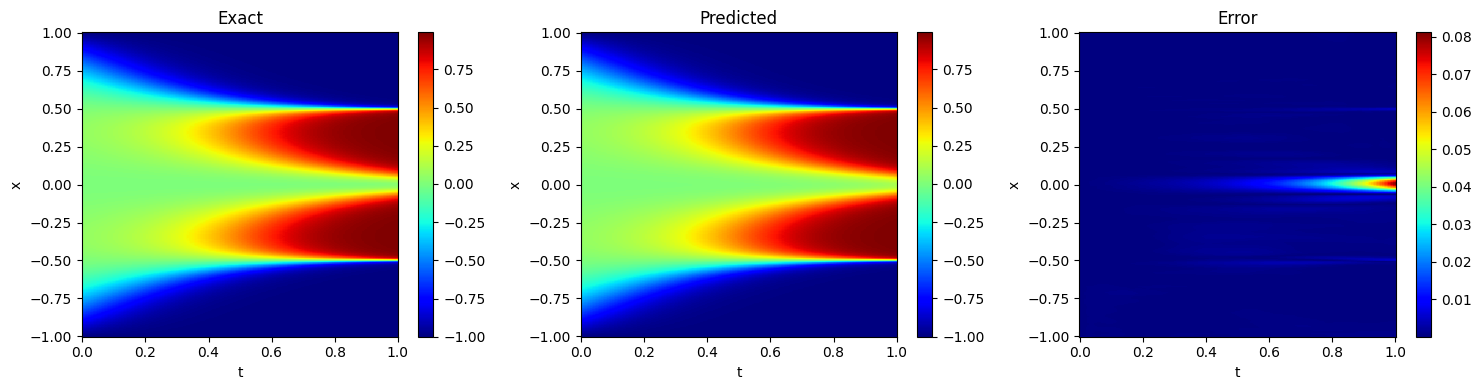

In [5]:
# Allen-Cahn IC/BC/PDE
def allen_cahn_ic(x):
    """Initial condition: u(0,x) = x^2 * cos(pi*x)"""
    return x**2 * jnp.cos(jnp.pi * x)

def allen_cahn_bc(params, u_net, t):
    """Periodic BC: u(-1,t) = u(1,t), u_x(-1,t) = u_x(1,t)"""
    u_l = u_net(params, t, -1.0)
    u_r = u_net(params, t, 1.0)
    ux_l = grad(u_net, argnums=2)(params, t, -1.0)
    ux_r = grad(u_net, argnums=2)(params, t, 1.0)
    return (u_l - u_r)**2 + (ux_l - ux_r)**2

def allen_cahn_pde(params, u_net, t, x):
    """PDE residual: u_t - 0.0001*u_xx + 5u^3 - 5u = 0"""
    u = u_net(params, t, x)
    u_t = grad(u_net, argnums=1)(params, t, x)
    u_xx = grad(grad(u_net, argnums=2), argnums=2)(params, t, x)
    return u_t - 0.0001 * u_xx + 5.0 * u**3 - 5.0 * u

# Configuration
CONFIG_ALLEN_CAHN = {
    'pde_type': 'allen_cahn',
    'domain': [[0.0, 1.0], [-1.0, 1.0]],  # [t, x]

    # Architecture
    'num_layers': 4,
    'hidden_dim': 128,
    'activation': 'tanh',
    'nonlinearity': 0.0,
    'fourier_scale': 2.0,
    'fourier_dim': 128,
    'use_reparam': True,

    # Training
    'learning_rate': 1e-3,
    'warmup_steps': 5000,
    'decay_steps': 5000,
    'decay_rate': 0.9,
    'lr_end': 1e-7,

    # Batch sizes
    'batch_size_res': 1024,
    'batch_size_ic': 128,
    'batch_size_bc': 128,

    # Weighting
    'use_ntk': True,
    'init_weights': {'ic': 1.0, 'bc': 1.0, 'res': 1.0},
    'weight_momentum': 0.9,

    # Causal
    'use_causal': True,
    'causal_tol': 1.0,
    'num_chunks': 32,

    'seed': 42,
    'csv_filename': 'loss_history_allen_cahn.csv',
}

# Load reference
data_mat = scipy.io.loadmat('/content/allen_cahn.mat')
u_ref_ac = data_mat['usol']
t_star_ac = data_mat['t'].flatten()
x_star_ac = data_mat['x'].flatten()

# Train
trainer_ac = VanillaPirateNetTrainer(CONFIG_ALLEN_CAHN)
trainer_ac.set_reference(t_star_ac, x_star_ac, u_ref_ac)
trainer_ac.set_pde_functions(allen_cahn_ic, allen_cahn_bc, allen_cahn_pde)
# Final layer initialization (lstsq)
def init_final_layer(trainer, ic_fn, x_min=-1.0, x_max=1.0):
    from flax.core import freeze, unfreeze
    n_ic = 512
    x_ic = jnp.linspace(x_min, x_max, n_ic)
    t_ic = jnp.zeros(n_ic)
    inputs = jnp.stack([t_ic, x_ic], axis=-1)
    u_target = ic_fn(x_ic).reshape(-1, 1)
    features, _ = trainer.model.apply(trainer.params, inputs)
    H = jnp.hstack([features, jnp.ones((n_ic, 1))])
    coeffs, _, _, _ = jnp.linalg.lstsq(H, u_target, rcond=None)
    W_new = coeffs[:-1]  # shape (hidden_dim, 1)
    b_new = coeffs[-1]   # shape (1,)
    params = unfreeze(trainer.params)
    for key in params['params']:
        if key.startswith('Dense') and 'block' not in key:
            layer = params['params'][key]
            if 'kernel' in layer:
                k = layer['kernel']
                if isinstance(k, tuple) and k[1].shape[-1] == 1:
                    # Weight fact: kernel = (g, v) where g=(out_dim,), v=(in_dim, out_dim)
                    # g * v gives the actual weight matrix
                    # Set g=1, v=W_new
                    params['params'][key]['kernel'] = (jnp.ones((1,)), W_new)
                    params['params'][key]['bias'] = b_new
                    break
    trainer.params = freeze(params)
    trainer.opt_state = trainer.tx.init(trainer.params)
    _, u_pred = trainer.model.apply(trainer.params, inputs)
    print(f"Final layer init (IC MSE: {jnp.mean((u_pred.flatten() - u_target.flatten())**2):.2e})")

init_final_layer(trainer_ac, allen_cahn_ic)
trainer_ac.train(n_iter=150000, log_every=4000, ntk_every=2000, diag_every=10000)

# Evaluate
u_pred_ac = trainer_ac.predict(t_star_ac, x_star_ac)
l2_err_ac = jnp.linalg.norm(u_pred_ac - u_ref_ac) / jnp.linalg.norm(u_ref_ac)
print(f"\nAllen-Cahn L2 Error: {l2_err_ac:.4e}")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, data, title in zip(axes, [u_ref_ac, u_pred_ac, jnp.abs(u_ref_ac - u_pred_ac)],
                            ['Exact', 'Predicted', 'Error']):
    im = ax.pcolormesh(t_star_ac, x_star_ac, data.T, cmap='jet', shading='auto')
    ax.set_xlabel('t'); ax.set_ylabel('x'); ax.set_title(title)
    plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.savefig('allen_cahn_results.png', dpi=150)
plt.show()

## Burgers Equation

$$u_t + u u_x = \nu u_{xx}$$

- Domain: $t \in [0,1]$, $x \in [-1,1]$
- IC: $u(0,x) = -\sin(\pi x)$
- BC: Dirichlet $u(-1,t) = u(1,t) = 0$
- Viscosity: $\nu = 0.01/\pi$

Final layer init (IC MSE: 2.72e-25)

Pure PirateNet - BURGERS
Training: 150000 steps
CSV: loss_history_burgers.csv


Training:   0%|          | 0/150000 [00:00<?, ?it/s]


[0] IC=2.46e-25 BC=8.17e+00 RES=4.27e+01


IC=2.5e-25 BC=8.2e+00 RES=4.3e+01:   0%|          | 5/150000 [00:11<70:06:57,  1.68s/it] 

  L2 Error: 2.0742e+00


IC=1.5e-02 BC=3.4e-04 RES=3.4e-02:   1%|▏         | 2005/150000 [02:05<27:04:21,  1.52it/s]

>>> NTK: IC=1.322 BC=2.235 RES=0.937


IC=2.2e-02 BC=5.0e-04 RES=2.9e-01:   3%|▎         | 4005/150000 [03:54<7:04:25,  5.73it/s] 

>>> NTK: IC=1.237 BC=6.493 RES=0.958


IC=2.3e-02 BC=7.4e-05 RES=1.7e-01:   4%|▍         | 6005/150000 [05:43<6:24:55,  6.23it/s] 

>>> NTK: IC=1.178 BC=6.701 RES=0.937


IC=1.0e-03 BC=1.7e-05 RES=2.2e-02:   5%|▌         | 8005/150000 [07:32<6:22:47,  6.18it/s] 

>>> NTK: IC=338.912 BC=443.596 RES=0.876


IC=2.5e-06 BC=6.1e-07 RES=1.6e-02:   7%|▋         | 10002/150000 [09:20<10:39:39,  3.65it/s]

>>> NTK: IC=409.967 BC=1678.544 RES=0.822

[10000] IC=2.55e-06 BC=6.12e-07 RES=1.59e-02
  L2 Error: 5.6376e-02


IC=4.8e-07 BC=6.4e-07 RES=3.1e-03:   8%|▊         | 12005/150000 [11:09<6:06:28,  6.28it/s] 

>>> NTK: IC=859.162 BC=2279.730 RES=0.773


IC=1.4e-06 BC=3.3e-07 RES=1.9e-03:   9%|▉         | 14005/150000 [12:57<6:38:31,  5.69it/s]

>>> NTK: IC=1126.143 BC=2320.703 RES=0.729


IC=3.6e-07 BC=2.0e-06 RES=2.5e-03:  11%|█         | 16005/150000 [14:45<6:00:07,  6.20it/s] 

>>> NTK: IC=2670.318 BC=2122.688 RES=0.690


IC=5.2e-06 BC=5.4e-06 RES=1.1e-02:  12%|█▏        | 18005/150000 [16:34<5:55:32,  6.19it/s] 

>>> NTK: IC=3721.978 BC=2113.675 RES=0.654


IC=4.5e-06 BC=7.4e-06 RES=3.8e-03:  13%|█▎        | 20002/150000 [18:22<10:00:46,  3.61it/s]

>>> NTK: IC=7156.130 BC=1917.332 RES=0.622

[20000] IC=4.55e-06 BC=7.40e-06 RES=3.81e-03
  L2 Error: 3.0280e-02


IC=1.5e-06 BC=3.2e-06 RES=2.4e-02:  15%|█▍        | 22005/150000 [20:10<5:42:24,  6.23it/s] 

>>> NTK: IC=12260.764 BC=2821.171 RES=0.593


IC=3.4e-06 BC=4.5e-06 RES=5.6e-03:  16%|█▌        | 24005/150000 [21:59<5:40:45,  6.16it/s]

>>> NTK: IC=11160.735 BC=2565.939 RES=0.567


IC=2.7e-06 BC=8.7e-06 RES=3.5e-03:  17%|█▋        | 26005/150000 [23:47<5:31:07,  6.24it/s]

>>> NTK: IC=18276.730 BC=2562.372 RES=0.544


IC=3.4e-07 BC=2.3e-07 RES=4.2e-03:  19%|█▊        | 28005/150000 [25:35<5:58:26,  5.67it/s]

>>> NTK: IC=22207.611 BC=3058.062 RES=0.523


IC=7.9e-07 BC=2.2e-06 RES=7.2e-03:  20%|██        | 30001/150000 [27:23<9:27:17,  3.53it/s]

>>> NTK: IC=24902.859 BC=2839.508 RES=0.504

[30000] IC=7.94e-07 BC=2.18e-06 RES=7.18e-03
  L2 Error: 3.9641e-02


IC=1.6e-07 BC=4.7e-07 RES=8.2e-03:  21%|██▏       | 32005/150000 [29:11<5:08:13,  6.38it/s]

>>> NTK: IC=31564.555 BC=5987.204 RES=0.487


IC=3.8e-07 BC=1.6e-06 RES=1.1e-02:  23%|██▎       | 34005/150000 [31:00<5:09:22,  6.25it/s]

>>> NTK: IC=33448.516 BC=8402.019 RES=0.471


IC=1.1e-06 BC=1.0e-06 RES=7.0e-03:  24%|██▍       | 36005/150000 [32:48<5:01:56,  6.29it/s]

>>> NTK: IC=31933.226 BC=7656.441 RES=0.458


IC=1.2e-07 BC=1.8e-07 RES=4.4e-02:  25%|██▌       | 38005/150000 [34:36<5:12:01,  5.98it/s]

>>> NTK: IC=38543.882 BC=15006.582 RES=0.445


IC=1.9e-07 BC=4.6e-07 RES=5.8e-03:  27%|██▋       | 40001/150000 [36:24<9:01:09,  3.39it/s]

>>> NTK: IC=42567.593 BC=15317.906 RES=0.434

[40000] IC=1.86e-07 BC=4.57e-07 RES=5.82e-03
  L2 Error: 1.1704e-01


IC=1.5e-07 BC=2.9e-07 RES=2.7e-03:  28%|██▊       | 42005/150000 [38:12<4:46:46,  6.28it/s]

>>> NTK: IC=43896.903 BC=14135.566 RES=0.424


IC=7.2e-07 BC=2.9e-06 RES=4.0e-03:  29%|██▉       | 44005/150000 [40:01<4:38:27,  6.34it/s]

>>> NTK: IC=41899.253 BC=13136.433 RES=0.415


IC=1.5e-07 BC=2.7e-06 RES=6.4e-03:  31%|███       | 46005/150000 [41:49<4:36:19,  6.27it/s]

>>> NTK: IC=45091.943 BC=15874.394 RES=0.407


IC=9.3e-08 BC=2.2e-07 RES=4.8e-03:  32%|███▏      | 48005/150000 [43:37<4:32:02,  6.25it/s]

>>> NTK: IC=43925.097 BC=15183.357 RES=0.399


IC=2.3e-06 BC=1.1e-06 RES=4.4e-03:  33%|███▎      | 50001/150000 [45:25<7:50:09,  3.54it/s]

>>> NTK: IC=43575.252 BC=13813.815 RES=0.393

[50000] IC=2.26e-06 BC=1.12e-06 RES=4.36e-03
  L2 Error: 6.6459e-02


IC=2.2e-08 BC=6.6e-08 RES=3.9e-03:  35%|███▍      | 52005/150000 [47:13<4:20:17,  6.27it/s]

>>> NTK: IC=48149.471 BC=17185.679 RES=0.387


IC=4.2e-07 BC=5.3e-07 RES=2.1e-03:  36%|███▌      | 54005/150000 [49:01<4:17:37,  6.21it/s]

>>> NTK: IC=45875.300 BC=15848.552 RES=0.382


IC=1.6e-07 BC=1.9e-07 RES=4.3e-03:  37%|███▋      | 56005/150000 [50:50<4:13:19,  6.18it/s]

>>> NTK: IC=51129.067 BC=19382.679 RES=0.377


IC=6.7e-07 BC=1.4e-06 RES=3.4e-03:  39%|███▊      | 58005/150000 [52:38<3:54:27,  6.54it/s]

>>> NTK: IC=47296.419 BC=17791.157 RES=0.372


IC=1.5e-08 BC=3.9e-08 RES=2.5e-03:  40%|████      | 60001/150000 [54:26<7:20:17,  3.41it/s]

>>> NTK: IC=51714.047 BC=24993.063 RES=0.368

[60000] IC=1.46e-08 BC=3.90e-08 RES=2.50e-03
  L2 Error: 5.6607e-02


IC=2.6e-07 BC=2.4e-06 RES=2.4e-03:  41%|████▏     | 62005/150000 [56:14<4:16:14,  5.72it/s]

>>> NTK: IC=53169.820 BC=22642.087 RES=0.365


IC=6.2e-08 BC=1.8e-07 RES=2.7e-03:  43%|████▎     | 64005/150000 [58:02<3:48:42,  6.27it/s]

>>> NTK: IC=51337.007 BC=25166.291 RES=0.362


IC=3.1e-08 BC=6.9e-08 RES=3.2e-03:  44%|████▍     | 66005/150000 [59:50<3:41:17,  6.33it/s]

>>> NTK: IC=55305.878 BC=27111.505 RES=0.359


IC=2.0e-07 BC=4.9e-07 RES=2.1e-03:  45%|████▌     | 68005/150000 [1:01:39<3:39:05,  6.24it/s]

>>> NTK: IC=56755.717 BC=25044.925 RES=0.356


IC=1.0e-07 BC=3.3e-07 RES=6.0e-03:  47%|████▋     | 70001/150000 [1:03:27<6:18:14,  3.53it/s]

>>> NTK: IC=52071.513 BC=23744.203 RES=0.354

[70000] IC=1.01e-07 BC=3.28e-07 RES=5.99e-03
  L2 Error: 7.0434e-02


IC=4.2e-08 BC=2.4e-07 RES=2.2e-03:  48%|████▊     | 72005/150000 [1:05:15<3:31:05,  6.16it/s]

>>> NTK: IC=55586.282 BC=23406.087 RES=0.352


IC=5.7e-08 BC=2.7e-07 RES=2.7e-03:  49%|████▉     | 74005/150000 [1:07:03<3:18:53,  6.37it/s]

>>> NTK: IC=57832.434 BC=27581.286 RES=0.350


IC=6.3e-08 BC=9.4e-07 RES=2.3e-03:  51%|█████     | 76005/150000 [1:08:51<3:18:21,  6.22it/s]

>>> NTK: IC=58712.866 BC=25471.199 RES=0.348


IC=5.5e-08 BC=4.9e-08 RES=1.4e-03:  52%|█████▏    | 78005/150000 [1:10:39<3:12:44,  6.23it/s]

>>> NTK: IC=55214.812 BC=24590.325 RES=0.347


IC=3.1e-08 BC=1.0e-07 RES=2.0e-03:  53%|█████▎    | 80001/150000 [1:12:28<5:31:59,  3.51it/s]

>>> NTK: IC=55155.487 BC=22562.122 RES=0.346

[80000] IC=3.05e-08 BC=1.02e-07 RES=2.00e-03
  L2 Error: 3.8042e-02


IC=1.6e-07 BC=5.1e-07 RES=1.1e-03:  55%|█████▍    | 82005/150000 [1:14:16<3:01:01,  6.26it/s]

>>> NTK: IC=50445.246 BC=21121.839 RES=0.344


IC=3.0e-08 BC=6.7e-08 RES=8.7e-04:  56%|█████▌    | 84005/150000 [1:16:04<2:55:51,  6.25it/s]

>>> NTK: IC=53714.378 BC=24152.969 RES=0.343


IC=1.8e-07 BC=2.0e-07 RES=1.2e-03:  57%|█████▋    | 86005/150000 [1:17:52<2:52:16,  6.19it/s]

>>> NTK: IC=48691.742 BC=21829.060 RES=0.342


IC=4.3e-08 BC=1.5e-07 RES=1.4e-03:  59%|█████▊    | 88005/150000 [1:19:40<2:54:38,  5.92it/s]

>>> NTK: IC=50374.499 BC=20565.807 RES=0.341


IC=9.0e-08 BC=9.2e-08 RES=6.6e-04:  60%|██████    | 90001/150000 [1:21:28<4:43:24,  3.53it/s]

>>> NTK: IC=45866.859 BC=18539.500 RES=0.341

[90000] IC=8.95e-08 BC=9.21e-08 RES=6.57e-04
  L2 Error: 2.3229e-02


IC=6.7e-08 BC=1.2e-07 RES=8.4e-04:  61%|██████▏   | 92005/150000 [1:23:17<2:36:38,  6.17it/s]

>>> NTK: IC=43444.870 BC=17681.650 RES=0.340


IC=1.7e-07 BC=3.5e-07 RES=1.4e-03:  63%|██████▎   | 94005/150000 [1:25:05<2:27:34,  6.32it/s]

>>> NTK: IC=39698.403 BC=16010.498 RES=0.339


IC=2.3e-08 BC=1.3e-07 RES=9.1e-04:  64%|██████▍   | 96005/150000 [1:26:53<2:23:17,  6.28it/s]

>>> NTK: IC=37204.750 BC=16037.569 RES=0.339


IC=4.2e-08 BC=2.9e-07 RES=4.8e-04:  65%|██████▌   | 98005/150000 [1:28:41<2:19:56,  6.19it/s]

>>> NTK: IC=41504.601 BC=17877.076 RES=0.338


IC=1.4e-08 BC=5.4e-08 RES=3.6e-04:  67%|██████▋   | 100002/150000 [1:30:29<3:51:30,  3.60it/s]

>>> NTK: IC=40036.339 BC=16305.881 RES=0.338

[100000] IC=1.43e-08 BC=5.45e-08 RES=3.56e-04
  L2 Error: 1.1561e-02


IC=3.2e-08 BC=1.0e-07 RES=3.9e-04:  68%|██████▊   | 102005/150000 [1:32:18<2:20:59,  5.67it/s]

>>> NTK: IC=38346.888 BC=15248.247 RES=0.337


IC=1.2e-08 BC=7.3e-09 RES=2.2e-04:  69%|██████▉   | 104005/150000 [1:34:06<2:02:56,  6.24it/s]

>>> NTK: IC=37450.062 BC=15026.477 RES=0.337


IC=8.6e-09 BC=1.0e-08 RES=2.8e-04:  71%|███████   | 106005/150000 [1:35:54<1:57:05,  6.26it/s]

>>> NTK: IC=41357.393 BC=14705.144 RES=0.336


IC=4.2e-09 BC=1.3e-08 RES=2.3e-04:  72%|███████▏  | 108005/150000 [1:37:42<1:52:23,  6.23it/s]

>>> NTK: IC=38748.281 BC=14197.643 RES=0.336


IC=1.2e-08 BC=2.9e-08 RES=2.7e-04:  73%|███████▎  | 110001/150000 [1:39:30<3:08:10,  3.54it/s]

>>> NTK: IC=37906.764 BC=13268.687 RES=0.336

[110000] IC=1.16e-08 BC=2.87e-08 RES=2.73e-04
  L2 Error: 8.2586e-03


IC=4.2e-09 BC=2.2e-08 RES=3.3e-04:  75%|███████▍  | 112005/150000 [1:41:19<1:41:04,  6.27it/s]

>>> NTK: IC=41826.522 BC=12365.520 RES=0.336


IC=4.8e-08 BC=7.6e-08 RES=6.2e-04:  76%|███████▌  | 114005/150000 [1:43:07<1:35:59,  6.25it/s]

>>> NTK: IC=41946.618 BC=12572.535 RES=0.335


IC=3.6e-08 BC=4.8e-08 RES=3.8e-04:  77%|███████▋  | 116005/150000 [1:44:55<1:31:11,  6.21it/s]

>>> NTK: IC=38456.910 BC=13898.596 RES=0.335


IC=1.2e-08 BC=4.9e-08 RES=1.6e-04:  79%|███████▊  | 118005/150000 [1:46:43<1:26:29,  6.17it/s]

>>> NTK: IC=40064.803 BC=12891.686 RES=0.335


IC=2.5e-08 BC=1.2e-07 RES=5.6e-04:  80%|████████  | 120002/150000 [1:48:31<2:17:35,  3.63it/s]

>>> NTK: IC=44883.849 BC=12035.468 RES=0.335

[120000] IC=2.53e-08 BC=1.17e-07 RES=5.60e-04
  L2 Error: 9.0915e-03


IC=1.3e-09 BC=3.6e-09 RES=2.1e-04:  81%|████████▏ | 122005/150000 [1:50:19<1:14:27,  6.27it/s]

>>> NTK: IC=49989.709 BC=14065.537 RES=0.335


IC=3.5e-09 BC=3.6e-09 RES=5.2e-04:  83%|████████▎ | 124005/150000 [1:52:07<1:09:20,  6.25it/s]

>>> NTK: IC=50119.396 BC=19715.287 RES=0.335


IC=6.8e-10 BC=1.6e-09 RES=3.2e-04:  84%|████████▍ | 126005/150000 [1:53:56<1:03:48,  6.27it/s]

>>> NTK: IC=54159.964 BC=25037.988 RES=0.334


IC=1.1e-07 BC=1.3e-07 RES=2.5e-04:  85%|████████▌ | 128005/150000 [1:55:44<59:02,  6.21it/s]  

>>> NTK: IC=49942.661 BC=23265.348 RES=0.334


IC=6.4e-09 BC=2.6e-08 RES=1.4e-04:  87%|████████▋ | 130001/150000 [1:57:32<1:34:45,  3.52it/s]

>>> NTK: IC=46950.466 BC=20954.789 RES=0.334

[130000] IC=6.40e-09 BC=2.65e-08 RES=1.43e-04
  L2 Error: 3.8698e-03


IC=2.3e-08 BC=7.0e-08 RES=2.2e-04:  88%|████████▊ | 132005/150000 [1:59:20<47:58,  6.25it/s]  

>>> NTK: IC=42774.843 BC=19095.578 RES=0.334


IC=1.5e-10 BC=2.2e-10 RES=8.2e-05:  89%|████████▉ | 134005/150000 [2:01:08<43:24,  6.14it/s]  

>>> NTK: IC=48113.265 BC=22911.557 RES=0.334


IC=4.8e-09 BC=1.2e-08 RES=1.1e-04:  91%|█████████ | 136005/150000 [2:02:57<37:07,  6.28it/s]  

>>> NTK: IC=46866.349 BC=21487.986 RES=0.334


IC=2.2e-09 BC=3.3e-09 RES=1.1e-04:  92%|█████████▏| 138005/150000 [2:04:45<31:47,  6.29it/s]

>>> NTK: IC=49096.111 BC=22811.366 RES=0.334


IC=3.9e-09 BC=6.2e-09 RES=1.7e-04:  93%|█████████▎| 140001/150000 [2:06:33<46:23,  3.59it/s]

>>> NTK: IC=51130.672 BC=22167.919 RES=0.334

[140000] IC=3.92e-09 BC=6.18e-09 RES=1.75e-04
  L2 Error: 2.2229e-03


IC=1.2e-09 BC=2.1e-09 RES=1.1e-04:  95%|█████████▍| 142005/150000 [2:08:21<21:26,  6.22it/s]

>>> NTK: IC=53509.044 BC=20548.141 RES=0.334


IC=1.7e-08 BC=3.5e-08 RES=1.3e-04:  96%|█████████▌| 144005/150000 [2:10:09<17:37,  5.67it/s]

>>> NTK: IC=54460.759 BC=18766.771 RES=0.334


IC=3.2e-08 BC=2.1e-08 RES=1.8e-04:  97%|█████████▋| 146005/150000 [2:11:58<10:41,  6.23it/s]

>>> NTK: IC=52068.532 BC=18430.155 RES=0.334


IC=2.7e-08 BC=9.0e-08 RES=1.0e-04:  99%|█████████▊| 148005/150000 [2:13:46<05:23,  6.16it/s]

>>> NTK: IC=47606.165 BC=16700.508 RES=0.334


IC=1.4e-10 BC=1.6e-10 RES=7.5e-05: 100%|██████████| 150000/150000 [2:15:32<00:00, 18.44it/s]



Training complete. CSV: loss_history_burgers.csv

Burgers L2 Error: 2.3038e-03


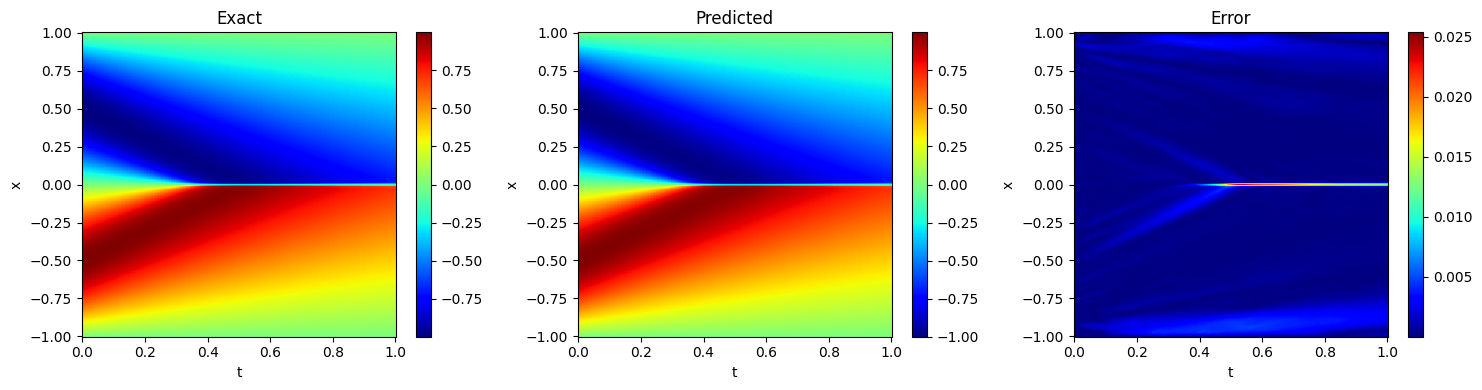

In [5]:
# Burgers IC/BC/PDE
def burgers_ic(x):
    """Initial condition: u(0,x) = -sin(pi*x)"""
    return -jnp.sin(jnp.pi * x)

def burgers_bc(params, u_net, t):
    """Dirichlet BC: u(-1,t) = u(1,t) = 0"""
    u_l = u_net(params, t, -1.0)
    u_r = u_net(params, t, 1.0)
    return u_l**2 + u_r**2

def burgers_pde(params, u_net, t, x, nu=0.01/jnp.pi):
    """PDE residual: u_t + u*u_x - nu*u_xx = 0"""
    u = u_net(params, t, x)
    u_t = grad(u_net, argnums=1)(params, t, x)
    u_x = grad(u_net, argnums=2)(params, t, x)
    u_xx = grad(grad(u_net, argnums=2), argnums=2)(params, t, x)
    return u_t + u * u_x - nu * u_xx

# Configuration
CONFIG_BURGERS = {
    'pde_type': 'burgers',
    'domain': [[0.0, 1.0], [-1.0, 1.0]],
    'num_layers': 4,
    'hidden_dim': 128,
    'activation': 'tanh',
    'nonlinearity': 0.0,
    'fourier_scale': 2.0,
    'fourier_dim': 128,
    'use_reparam': True,
    'learning_rate': 1e-3,
    'warmup_steps': 5000,
    'decay_steps': 5000,
    'decay_rate': 0.9,
    'lr_end': 1e-7,
    'batch_size_res': 1024,
    'batch_size_ic': 128,
    'batch_size_bc': 128,
    'use_ntk': True,
    'init_weights': {'ic': 1.0, 'bc': 1.0, 'res': 1.0},
    'weight_momentum': 0.9,
    'use_causal': True,
    'causal_tol': 1.0,
    'num_chunks': 32,
    'seed': 42,
    'csv_filename': 'loss_history_burgers.csv',
}

# Load reference
data_mat = scipy.io.loadmat('burgers.mat')
u_ref_bg = data_mat['usol']
t_star_bg = data_mat['t'].flatten()
x_star_bg = data_mat['x'].flatten()

# Train
trainer_bg = VanillaPirateNetTrainer(CONFIG_BURGERS)
trainer_bg.set_reference(t_star_bg, x_star_bg, u_ref_bg)
trainer_bg.set_pde_functions(burgers_ic, burgers_bc, burgers_pde)
# Final layer initialization (lstsq)
def init_final_layer(trainer, ic_fn, x_min=-1.0, x_max=1.0):
    from flax.core import freeze, unfreeze
    n_ic = 512
    x_ic = jnp.linspace(x_min, x_max, n_ic)
    t_ic = jnp.zeros(n_ic)
    inputs = jnp.stack([t_ic, x_ic], axis=-1)
    u_target = ic_fn(x_ic).reshape(-1, 1)
    features, _ = trainer.model.apply(trainer.params, inputs)
    H = jnp.hstack([features, jnp.ones((n_ic, 1))])
    coeffs, _, _, _ = jnp.linalg.lstsq(H, u_target, rcond=None)
    W_new = coeffs[:-1]  # shape (hidden_dim, 1)
    b_new = coeffs[-1]   # shape (1,)
    params = unfreeze(trainer.params)
    for key in params['params']:
        if key.startswith('Dense') and 'block' not in key:
            layer = params['params'][key]
            if 'kernel' in layer:
                k = layer['kernel']
                if isinstance(k, tuple) and k[1].shape[-1] == 1:
                    # Weight fact: kernel = (g, v) where g=(out_dim,), v=(in_dim, out_dim)
                    # g * v gives the actual weight matrix
                    # Set g=1, v=W_new
                    params['params'][key]['kernel'] = (jnp.ones((1,)), W_new)
                    params['params'][key]['bias'] = b_new
                    break
    trainer.params = freeze(params)
    trainer.opt_state = trainer.tx.init(trainer.params)
    _, u_pred = trainer.model.apply(trainer.params, inputs)
    print(f"Final layer init (IC MSE: {jnp.mean((u_pred.flatten() - u_target.flatten())**2):.2e})")

init_final_layer(trainer_bg, burgers_ic)
trainer_bg.train(n_iter=150000, log_every=4000, ntk_every=2000, diag_every=10000)

# Evaluate
u_pred_bg = trainer_bg.predict(t_star_bg, x_star_bg)
l2_err_bg = jnp.linalg.norm(u_pred_bg - u_ref_bg) / jnp.linalg.norm(u_ref_bg)
print(f"\nBurgers L2 Error: {l2_err_bg:.4e}")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, data, title in zip(axes, [u_ref_bg, u_pred_bg, jnp.abs(u_ref_bg - u_pred_bg)],
                            ['Exact', 'Predicted', 'Error']):
    im = ax.pcolormesh(t_star_bg, x_star_bg, data.T, cmap='jet', shading='auto')
    ax.set_xlabel('t'); ax.set_ylabel('x'); ax.set_title(title)
    plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.savefig('burgers_results.png', dpi=150)
plt.show()

## Korteweg-de Vries (KdV) Equation

$$u_t + \eta u u_x + \mu^2 u_{xxx} = 0$$

- Domain: $t \in [0,1]$, $x \in [-1,1]$
- IC: $u(0,x) = \cos(\pi x)$
- BC: Periodic
- Parameters: $\eta = 1$, $\mu = 0.022$

Final layer init (IC MSE: 1.20e-27)

Pure PirateNet - KDV
Training: 150000 steps
CSV: loss_history_kdv.csv


IC=1.1e-27 BC=5.9e+01 RES=1.0e+03:   0%|          | 10/150000 [00:36<108:52:41,  2.61s/it]


[0] IC=1.15e-27 BC=5.90e+01 RES=9.99e+02
  L2 Error: 5.6395e+00


IC=5.6e-03 BC=7.8e-04 RES=6.9e+01:   1%|▏         | 2015/150000 [01:08<8:40:45,  4.74it/s] 

>>> NTK: IC=2.154 BC=4.217 RES=0.935


IC=2.9e-03 BC=2.6e-04 RES=1.3e+01:   3%|▎         | 4010/150000 [01:38<10:27:23,  3.88it/s]

>>> NTK: IC=2.393 BC=3.975 RES=0.886


IC=4.5e-03 BC=4.6e-04 RES=9.0e+00:   4%|▍         | 6010/150000 [02:09<7:33:24,  5.29it/s] 

>>> NTK: IC=2.647 BC=3.955 RES=0.837


IC=3.2e-03 BC=2.2e-03 RES=8.3e+00:   5%|▌         | 8017/150000 [02:40<6:46:32,  5.82it/s]

>>> NTK: IC=2.873 BC=3.684 RES=0.803


IC=2.4e-03 BC=5.7e-04 RES=5.7e+00:   7%|▋         | 10004/150000 [03:11<10:05:36,  3.85it/s]

>>> NTK: IC=20.921 BC=4.617 RES=0.757

[10000] IC=2.41e-03 BC=5.69e-04 RES=5.72e+00
  L2 Error: 5.7725e-01


IC=1.4e-04 BC=1.6e-04 RES=5.8e+00:   8%|▊         | 12016/150000 [03:36<5:53:01,  6.51it/s]

>>> NTK: IC=24.219 BC=11.754 RES=0.715


IC=2.9e-05 BC=2.8e-05 RES=6.6e+00:   9%|▉         | 14013/150000 [04:02<5:40:28,  6.66it/s]

>>> NTK: IC=26.499 BC=12.596 RES=0.678


IC=6.3e-05 BC=7.4e-05 RES=5.8e+00:  11%|█         | 16018/150000 [04:27<5:37:41,  6.61it/s]

>>> NTK: IC=29.291 BC=11.973 RES=0.646


IC=4.9e-05 BC=6.4e-05 RES=4.2e+00:  12%|█▏        | 18014/150000 [04:53<5:31:51,  6.63it/s]

>>> NTK: IC=255.609 BC=12.456 RES=0.615


IC=6.6e-06 BC=3.3e-06 RES=4.1e+00:  13%|█▎        | 20004/150000 [05:18<7:31:28,  4.80it/s]

>>> NTK: IC=250.743 BC=20.607 RES=0.587

[20000] IC=6.60e-06 BC=3.33e-06 RES=4.12e+00
  L2 Error: 5.2310e-01


IC=4.0e-06 BC=1.9e-05 RES=2.9e+00:  15%|█▍        | 22012/150000 [05:43<5:19:25,  6.68it/s]

>>> NTK: IC=603.756 BC=212.412 RES=0.562


IC=2.8e-06 BC=1.1e-05 RES=4.1e+00:  16%|█▌        | 24012/150000 [06:09<7:14:45,  4.83it/s]

>>> NTK: IC=611.623 BC=197.241 RES=0.539


IC=4.1e-06 BC=1.5e-05 RES=2.6e+00:  17%|█▋        | 26019/150000 [06:34<5:08:01,  6.71it/s]

>>> NTK: IC=763.550 BC=187.952 RES=0.519


IC=8.9e-06 BC=7.6e-06 RES=2.6e+00:  19%|█▊        | 28012/150000 [07:00<5:26:45,  6.22it/s]

>>> NTK: IC=1380.879 BC=298.253 RES=0.500


IC=6.4e-06 BC=2.4e-05 RES=1.3e+00:  20%|██        | 30007/150000 [07:26<6:44:50,  4.94it/s]

>>> NTK: IC=1280.046 BC=305.454 RES=0.483

[30000] IC=6.42e-06 BC=2.45e-05 RES=1.30e+00
  L2 Error: 3.9448e-01


IC=4.5e-06 BC=4.2e-06 RES=1.4e+00:  21%|██▏       | 32013/150000 [07:51<4:52:39,  6.72it/s]

>>> NTK: IC=1283.702 BC=2183.292 RES=0.468


IC=8.0e-08 BC=7.6e-07 RES=3.0e+00:  23%|██▎       | 34019/150000 [08:17<5:09:31,  6.24it/s]

>>> NTK: IC=4117.038 BC=2212.051 RES=0.455


IC=5.4e-08 BC=1.7e-07 RES=2.9e+00:  24%|██▍       | 36021/150000 [08:43<4:42:54,  6.71it/s]

>>> NTK: IC=11145.590 BC=8988.116 RES=0.443


IC=2.9e-08 BC=8.2e-08 RES=3.9e+00:  25%|██▌       | 38012/150000 [09:08<6:34:17,  4.73it/s]

>>> NTK: IC=17340.437 BC=9705.567 RES=0.432


IC=5.6e-08 BC=2.2e-07 RES=4.7e+00:  27%|██▋       | 40005/150000 [09:34<6:07:13,  4.99it/s]

>>> NTK: IC=16326.909 BC=8879.353 RES=0.422

[40000] IC=5.57e-08 BC=2.20e-07 RES=4.71e+00
  L2 Error: 5.2127e-01


IC=1.9e-06 BC=3.8e-06 RES=4.6e+00:  28%|██▊       | 42015/150000 [09:59<4:37:21,  6.49it/s]

>>> NTK: IC=14753.610 BC=7998.500 RES=0.413


IC=4.0e-07 BC=1.7e-06 RES=5.6e+00:  29%|██▉       | 44011/150000 [10:25<6:12:30,  4.74it/s]

>>> NTK: IC=16517.445 BC=7333.062 RES=0.405


IC=9.2e-06 BC=1.6e-05 RES=2.6e+00:  31%|███       | 46019/150000 [10:50<4:19:35,  6.68it/s]

>>> NTK: IC=14920.480 BC=6667.978 RES=0.398


IC=5.7e-07 BC=8.5e-07 RES=2.3e+00:  32%|███▏      | 48017/150000 [11:16<4:21:52,  6.49it/s]

>>> NTK: IC=13585.252 BC=6160.942 RES=0.392


IC=2.1e-06 BC=2.4e-06 RES=4.2e+00:  33%|███▎      | 50012/150000 [11:42<4:24:25,  6.30it/s]

>>> NTK: IC=12446.471 BC=7044.510 RES=0.386

[50000] IC=2.11e-06 BC=2.41e-06 RES=4.23e+00
  L2 Error: 5.1465e-01


IC=1.6e-07 BC=5.5e-07 RES=3.6e+00:  35%|███▍      | 52017/150000 [12:07<4:04:17,  6.68it/s]

>>> NTK: IC=13048.328 BC=9632.345 RES=0.381


IC=1.6e-08 BC=3.2e-08 RES=2.5e+00:  36%|███▌      | 54014/150000 [12:33<4:00:15,  6.66it/s]

>>> NTK: IC=20962.812 BC=18624.382 RES=0.376


IC=8.6e-08 BC=2.8e-07 RES=3.4e+00:  37%|███▋      | 56016/150000 [12:59<4:06:56,  6.34it/s]

>>> NTK: IC=20066.411 BC=19282.008 RES=0.372


IC=7.0e-09 BC=2.9e-08 RES=3.4e+00:  39%|███▊      | 58014/150000 [13:24<3:51:00,  6.64it/s]

>>> NTK: IC=27974.875 BC=19998.931 RES=0.368


IC=2.9e-07 BC=2.0e-06 RES=2.6e+00:  40%|████      | 60005/150000 [13:49<5:07:37,  4.88it/s]

>>> NTK: IC=31951.776 BC=18445.625 RES=0.364

[60000] IC=2.91e-07 BC=2.00e-06 RES=2.61e+00
  L2 Error: 4.8270e-01


IC=6.4e-07 BC=8.3e-07 RES=2.9e+00:  41%|████▏     | 62012/150000 [14:15<5:01:37,  4.86it/s]

>>> NTK: IC=30770.047 BC=16826.069 RES=0.361


IC=2.0e-07 BC=2.8e-07 RES=2.4e+00:  43%|████▎     | 64011/150000 [14:40<4:59:29,  4.79it/s]

>>> NTK: IC=28456.576 BC=15431.491 RES=0.358


IC=3.4e-07 BC=8.8e-08 RES=2.2e+00:  44%|████▍     | 66011/150000 [15:06<3:35:09,  6.51it/s]

>>> NTK: IC=27229.989 BC=16344.136 RES=0.356


IC=6.8e-09 BC=2.9e-08 RES=2.2e+00:  45%|████▌     | 68014/150000 [15:32<3:39:16,  6.23it/s]

>>> NTK: IC=28886.635 BC=24464.716 RES=0.354


IC=1.3e-07 BC=2.1e-07 RES=3.6e+00:  47%|████▋     | 70011/150000 [15:57<4:28:54,  4.96it/s]

>>> NTK: IC=26929.367 BC=23977.032 RES=0.352

[70000] IC=1.31e-07 BC=2.09e-07 RES=3.57e+00
  L2 Error: 4.6505e-01


IC=2.0e-07 BC=8.2e-08 RES=2.7e+00:  48%|████▊     | 72020/150000 [16:23<3:22:54,  6.41it/s]

>>> NTK: IC=27504.301 BC=25750.989 RES=0.350


IC=1.2e-07 BC=3.2e-07 RES=3.0e+00:  49%|████▉     | 74018/150000 [16:48<3:11:45,  6.60it/s]

>>> NTK: IC=32264.459 BC=30224.316 RES=0.348


IC=2.3e-08 BC=3.7e-08 RES=2.7e+00:  51%|█████     | 76015/150000 [17:13<3:03:43,  6.71it/s]

>>> NTK: IC=36032.257 BC=36715.142 RES=0.347


IC=4.6e-08 BC=1.6e-07 RES=3.0e+00:  52%|█████▏    | 78014/150000 [17:39<3:04:27,  6.50it/s]

>>> NTK: IC=41588.570 BC=38547.298 RES=0.345


IC=4.2e-08 BC=9.3e-07 RES=2.3e+00:  53%|█████▎    | 80003/150000 [18:05<3:57:13,  4.92it/s]

>>> NTK: IC=43120.540 BC=35417.748 RES=0.344

[80000] IC=4.24e-08 BC=9.34e-07 RES=2.30e+00
  L2 Error: 4.5208e-01


IC=4.8e-08 BC=8.9e-07 RES=2.7e+00:  55%|█████▍    | 82021/150000 [18:30<2:52:27,  6.57it/s]

>>> NTK: IC=45888.066 BC=32224.617 RES=0.343


IC=7.8e-08 BC=3.4e-08 RES=2.7e+00:  56%|█████▌    | 84011/150000 [18:56<3:48:53,  4.80it/s]

>>> NTK: IC=47410.508 BC=37772.970 RES=0.342


IC=1.4e-08 BC=6.7e-08 RES=2.4e+00:  57%|█████▋    | 86011/150000 [19:21<3:36:44,  4.92it/s]

>>> NTK: IC=50431.817 BC=43735.089 RES=0.341


IC=1.8e-07 BC=2.4e-07 RES=2.8e+00:  59%|█████▊    | 88015/150000 [19:47<2:42:55,  6.34it/s]

>>> NTK: IC=46639.778 BC=41622.400 RES=0.340


IC=1.2e-07 BC=1.0e-07 RES=2.3e+00:  60%|██████    | 90006/150000 [20:13<3:28:57,  4.79it/s]

>>> NTK: IC=45082.221 BC=40391.973 RES=0.340

[90000] IC=1.19e-07 BC=1.03e-07 RES=2.30e+00
  L2 Error: 4.4915e-01


IC=2.2e-08 BC=2.3e-07 RES=2.2e+00:  61%|██████▏   | 92018/150000 [20:38<2:29:22,  6.47it/s]

>>> NTK: IC=48254.387 BC=36870.885 RES=0.339


IC=4.8e-07 BC=8.2e-08 RES=2.0e+00:  63%|██████▎   | 94018/150000 [21:04<2:23:14,  6.51it/s]

>>> NTK: IC=49230.477 BC=40265.011 RES=0.339


IC=1.3e-07 BC=1.9e-07 RES=2.1e+00:  64%|██████▍   | 96015/150000 [21:29<2:19:01,  6.47it/s]

>>> NTK: IC=47052.549 BC=37592.468 RES=0.338


IC=4.2e-08 BC=3.6e-07 RES=1.8e+00:  65%|██████▌   | 98011/150000 [21:55<3:03:47,  4.71it/s]

>>> NTK: IC=48147.493 BC=39774.337 RES=0.338


IC=1.7e-07 BC=1.9e-07 RES=1.7e+00:  67%|██████▋   | 100007/150000 [22:21<2:55:00,  4.76it/s]

>>> NTK: IC=52325.700 BC=42307.933 RES=0.337

[100000] IC=1.65e-07 BC=1.95e-07 RES=1.74e+00
  L2 Error: 4.4813e-01


IC=5.8e-08 BC=2.3e-08 RES=1.9e+00:  68%|██████▊   | 102016/150000 [22:46<2:03:06,  6.50it/s]

>>> NTK: IC=55602.422 BC=48033.112 RES=0.337


IC=7.4e-08 BC=3.1e-07 RES=1.7e+00:  69%|██████▉   | 104015/150000 [23:12<1:57:31,  6.52it/s]

>>> NTK: IC=55704.425 BC=52759.399 RES=0.336


IC=1.4e-08 BC=1.4e-07 RES=1.7e+00:  71%|███████   | 106011/150000 [23:37<2:42:12,  4.52it/s]

>>> NTK: IC=60094.362 BC=54110.429 RES=0.336


IC=4.3e-08 BC=5.4e-07 RES=9.4e-01:  72%|███████▏  | 108018/150000 [24:03<1:52:36,  6.21it/s]

>>> NTK: IC=55530.664 BC=49283.995 RES=0.336


IC=1.4e-08 BC=3.6e-08 RES=1.1e+00:  73%|███████▎  | 110008/150000 [24:29<2:16:30,  4.88it/s]

>>> NTK: IC=59783.303 BC=51269.834 RES=0.336

[110000] IC=1.38e-08 BC=3.61e-08 RES=1.07e+00
  L2 Error: 4.4092e-01


IC=5.3e-09 BC=3.5e-09 RES=1.4e+00:  75%|███████▍  | 112018/150000 [24:54<1:37:49,  6.47it/s]

>>> NTK: IC=63586.153 BC=55895.186 RES=0.335


IC=8.8e-08 BC=5.1e-08 RES=1.1e+00:  76%|███████▌  | 114019/150000 [25:20<1:29:33,  6.70it/s]

>>> NTK: IC=60606.193 BC=57075.243 RES=0.335


IC=1.3e-08 BC=8.6e-08 RES=7.4e-01:  77%|███████▋  | 116013/150000 [25:45<1:26:11,  6.57it/s]

>>> NTK: IC=63247.852 BC=54126.738 RES=0.335


IC=3.4e-09 BC=5.3e-09 RES=6.0e-01:  79%|███████▊  | 118014/150000 [26:11<1:24:22,  6.32it/s]

>>> NTK: IC=64853.172 BC=58609.557 RES=0.335


IC=4.7e-08 BC=2.9e-08 RES=5.5e-01:  80%|████████  | 120012/150000 [26:36<1:41:10,  4.94it/s]

>>> NTK: IC=64959.422 BC=59737.767 RES=0.335

[120000] IC=4.68e-08 BC=2.89e-08 RES=5.48e-01
  L2 Error: 4.3583e-01


IC=1.4e-08 BC=1.7e-08 RES=4.2e-01:  81%|████████▏ | 122019/150000 [27:02<1:10:45,  6.59it/s]

>>> NTK: IC=66288.157 BC=61903.142 RES=0.335


IC=2.9e-09 BC=6.3e-09 RES=3.5e-01:  83%|████████▎ | 124017/150000 [27:27<1:06:50,  6.48it/s]

>>> NTK: IC=68947.661 BC=65707.907 RES=0.334


IC=1.6e-07 BC=2.8e-07 RES=3.5e-01:  84%|████████▍ | 126016/150000 [27:53<1:02:21,  6.41it/s]

>>> NTK: IC=62851.209 BC=60251.620 RES=0.334


IC=4.4e-08 BC=1.1e-07 RES=2.6e-01:  85%|████████▌ | 128014/150000 [28:19<56:44,  6.46it/s]  

>>> NTK: IC=66278.597 BC=64132.784 RES=0.334


IC=4.3e-08 BC=4.8e-07 RES=2.5e-01:  87%|████████▋ | 130012/150000 [28:44<1:07:15,  4.95it/s]

>>> NTK: IC=61510.511 BC=60873.640 RES=0.334

[130000] IC=4.27e-08 BC=4.76e-07 RES=2.50e-01
  L2 Error: 4.3050e-01


IC=3.6e-09 BC=6.9e-09 RES=2.2e-01:  88%|████████▊ | 132011/150000 [29:09<1:01:05,  4.91it/s]

>>> NTK: IC=65135.814 BC=64753.790 RES=0.334


IC=1.9e-09 BC=2.0e-09 RES=1.9e-01:  89%|████████▉ | 134013/150000 [29:35<40:37,  6.56it/s]

>>> NTK: IC=68579.570 BC=68209.946 RES=0.334


IC=1.4e-08 BC=4.9e-08 RES=1.7e-01:  91%|█████████ | 136014/150000 [30:01<35:04,  6.65it/s]

>>> NTK: IC=71471.002 BC=67094.258 RES=0.334


IC=8.8e-08 BC=1.6e-07 RES=9.3e-02:  92%|█████████▏| 138011/150000 [30:26<42:01,  4.75it/s] 

>>> NTK: IC=73789.760 BC=66353.885 RES=0.334


IC=1.4e-09 BC=1.7e-09 RES=9.9e-02:  93%|█████████▎| 140007/150000 [30:51<33:07,  5.03it/s] 

>>> NTK: IC=76095.880 BC=69698.970 RES=0.334

[140000] IC=1.35e-09 BC=1.72e-09 RES=9.88e-02
  L2 Error: 4.0594e-01


IC=5.6e-09 BC=1.5e-08 RES=9.0e-02:  95%|█████████▍| 142015/150000 [31:17<20:28,  6.50it/s]

>>> NTK: IC=78216.641 BC=72458.024 RES=0.334


IC=2.8e-08 BC=6.0e-08 RES=7.3e-02:  96%|█████████▌| 144020/150000 [31:43<15:55,  6.26it/s]

>>> NTK: IC=78574.843 BC=74324.385 RES=0.334


IC=1.5e-09 BC=1.8e-08 RES=7.1e-02:  97%|█████████▋| 146019/150000 [32:09<10:17,  6.45it/s]

>>> NTK: IC=80275.152 BC=76296.092 RES=0.334


IC=4.9e-09 BC=3.6e-08 RES=6.0e-02:  99%|█████████▊| 148019/150000 [32:35<05:16,  6.26it/s]

>>> NTK: IC=81835.832 BC=75709.681 RES=0.334


IC=1.9e-09 BC=9.2e-09 RES=4.8e-02: 100%|██████████| 150000/150000 [32:52<00:00, 76.04it/s] 



Training complete. CSV: loss_history_kdv.csv

KdV L2 Error: 3.7921e-01


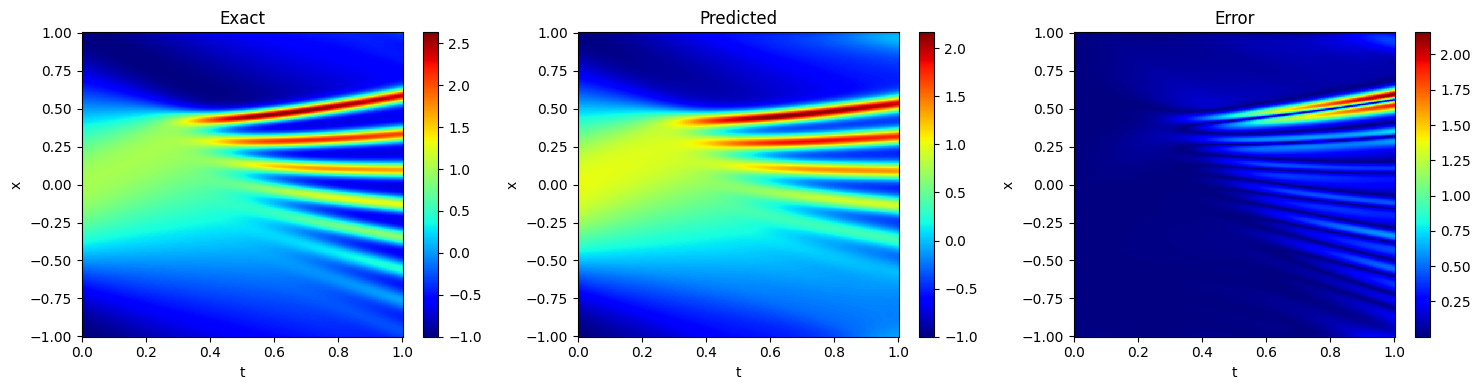

In [6]:
# KdV IC/BC/PDE
def kdv_ic(x):
    """Initial condition: u(0,x) = cos(pi*x)"""
    return jnp.cos(jnp.pi * x)

def kdv_bc(params, u_net, t):
    """Periodic BC: u(-1,t) = u(1,t)"""
    u_l = u_net(params, t, -1.0)
    u_r = u_net(params, t, 1.0)
    return (u_l - u_r)**2

def kdv_pde(params, u_net, t, x, eta=1.0, mu=0.022):
    """PDE residual: u_t + eta*u*u_x + mu^2*u_xxx = 0"""
    u = u_net(params, t, x)
    u_t = grad(u_net, argnums=1)(params, t, x)
    u_x = grad(u_net, argnums=2)(params, t, x)
    u_xxx = grad(grad(grad(u_net, argnums=2), argnums=2), argnums=2)(params, t, x)
    return u_t + eta * u * u_x + mu**2 * u_xxx

# Configuration
CONFIG_KDV = {
    'pde_type': 'kdv',
    'domain': [[0.0, 1.0], [-1.0, 1.0]],
    'num_layers': 4,
    'hidden_dim': 128,
    'activation': 'tanh',
    'nonlinearity': 0.0,
    'fourier_scale': 2.0,
    'fourier_dim': 128,
    'use_reparam': True,
    'learning_rate': 1e-3,
    'warmup_steps': 5000,
    'decay_steps': 5000,
    'decay_rate': 0.9,
    'lr_end': 1e-7,
    'batch_size_res': 1024,
    'batch_size_ic': 128,
    'batch_size_bc': 128,
    'use_ntk': True,
    'init_weights': {'ic': 1.0, 'bc': 1.0, 'res': 1.0},
    'weight_momentum': 0.9,
    'use_causal': True,
    'causal_tol': 1.0,
    'num_chunks': 32,
    'seed': 42,
    'csv_filename': 'loss_history_kdv.csv',
}

# KdV - Load reference
data_mat = scipy.io.loadmat('/content/kdv.mat')
u_ref_kdv = data_mat['usol']
t_star_kdv = data_mat['t'].flatten()
x_star_kdv = data_mat['x'].flatten()

# Train
trainer_kdv = VanillaPirateNetTrainer(CONFIG_KDV)
trainer_kdv.set_reference(t_star_kdv, x_star_kdv, u_ref_kdv)
trainer_kdv.set_pde_functions(kdv_ic, kdv_bc, kdv_pde)
# Final layer initialization (lstsq)
def init_final_layer(trainer, ic_fn, x_min=-1.0, x_max=1.0):
    from flax.core import freeze, unfreeze
    n_ic = 512
    x_ic = jnp.linspace(x_min, x_max, n_ic)
    t_ic = jnp.zeros(n_ic)
    inputs = jnp.stack([t_ic, x_ic], axis=-1)
    u_target = ic_fn(x_ic).reshape(-1, 1)
    features, _ = trainer.model.apply(trainer.params, inputs)
    H = jnp.hstack([features, jnp.ones((n_ic, 1))])
    coeffs, _, _, _ = jnp.linalg.lstsq(H, u_target, rcond=None)
    W_new = coeffs[:-1]  # shape (hidden_dim, 1)
    b_new = coeffs[-1]   # shape (1,)
    params = unfreeze(trainer.params)
    for key in params['params']:
        if key.startswith('Dense') and 'block' not in key:
            layer = params['params'][key]
            if 'kernel' in layer:
                k = layer['kernel']
                if isinstance(k, tuple) and k[1].shape[-1] == 1:
                    # Weight fact: kernel = (g, v) where g=(out_dim,), v=(in_dim, out_dim)
                    # g * v gives the actual weight matrix
                    # Set g=1, v=W_new
                    params['params'][key]['kernel'] = (jnp.ones((1,)), W_new)
                    params['params'][key]['bias'] = b_new
                    break
    trainer.params = freeze(params)
    trainer.opt_state = trainer.tx.init(trainer.params)
    _, u_pred = trainer.model.apply(trainer.params, inputs)
    print(f"Final layer init (IC MSE: {jnp.mean((u_pred.flatten() - u_target.flatten())**2):.2e})")

init_final_layer(trainer_kdv, kdv_ic)
trainer_kdv.train(n_iter=150000, log_every=4000, ntk_every=2000, diag_every=10000)

# Evaluate
u_pred_kdv = trainer_kdv.predict(t_star_kdv, x_star_kdv)
l2_err_kdv = jnp.linalg.norm(u_pred_kdv - u_ref_kdv) / jnp.linalg.norm(u_ref_kdv)
print(f"\nKdV L2 Error: {l2_err_kdv:.4e}")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, data, title in zip(axes, [u_ref_kdv, u_pred_kdv, jnp.abs(u_ref_kdv - u_pred_kdv)],
                            ['Exact', 'Predicted', 'Error']):
    im = ax.pcolormesh(t_star_kdv, x_star_kdv, data.T, cmap='jet', shading='auto')
    ax.set_xlabel('t'); ax.set_ylabel('x'); ax.set_title(title)
    plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.savefig('kdv_results.png', dpi=150)
plt.show()